# Using an AI model to determine the shell integrity of eggs

## Introduction

While looking through Kaggle's datasets, I found some funny ones, including some that determine whether an image contains a platypus, or perry the platypus, or one that determines if an image contains dog poop. I went with the data set that contained cracked or good eggs. This seemed a little more class appropriate but I may mess with those later.

The dataset found here: https://www.kaggle.com/datasets/frankpereny/broken-eggs?resource=download, contains several folders of data. This includes training images and testing images. These folders are then split into folders with images of cracked eggs, no eggs and eggs without cracks. I can and may add more egg images mysef to allow the model to analyze more images. 

My goal with these images is to make a quick AI model to determine if an egg is cracked or not, or an egg is missing as the else option. While silly, I think this could and may be used in processing of eggs at farms. The model can alert the egg sorting system to remove broken eggs in cartons or missing eggs if needed. It can serve as a quality assurance measure as well if trained with different images.

To create an AI model to determine egg shell integrity, we have to go through several steps. First, we can download the data and create a repository so that our python notebook is contained with the data we will be using. Then, we can initialize our python notebook by importing libraries/modules like numpy or pandas because we will likely need to use that later.

Then, we can begin opening, reading, visualizing and pre processing our image data based on what we think would help best. Maybe instead of RGB images of eggs, we want to process greyscale images because it results in a better model. We will have to do some testing.

We can create a basic model by importing tensorflow and keras models to work from. Then, just add different layers that will read and modify how the images are read, until we can successfully determine the integrity of egg shells. A lot of tuning can also be done to further improve the model.

## Importing and Data Pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.image as mpimg
import seaborn as sns
import skimage.io
from skimage import transform

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from helpers_plot_history import plot_history # Some helper functions for the CNN notebooks.

Note, the images from the dataset in the Introduction are 960x720 pixels JPGs! Remember to add the extension .jpg when reading the images with whatever library you choose. For me, I have used ski.image.io in the past so I will first try that and see how that goes. I will be defining function to just show some images first.

In [2]:
def display(image):
    """
    Displays "image" on simple axes for general visualization
    """
    with sns.axes_style('dark'):
        plt.figure(figsize=(12,10))
        plt.imshow(image)
        
        
def rImage(file_path):
    """
    Loads image data from "file_path." Size of image doesn't matter.
    """
    data = skimage.io.imread(file_path)
    return data

[[[ 80  80  82]
  [ 80  80  82]
  [ 80  80  82]
  ...
  [107 106 112]
  [106 105 111]
  [106 105 111]]

 [[ 80  80  82]
  [ 80  80  82]
  [ 80  80  82]
  ...
  [107 106 112]
  [106 105 111]
  [106 105 111]]

 [[ 80  80  82]
  [ 79  79  81]
  [ 80  80  82]
  ...
  [106 105 111]
  [106 105 111]
  [106 105 111]]

 ...

 [[114 114 116]
  [114 114 116]
  [114 114 116]
  ...
  [127 126 131]
  [127 126 131]
  [126 125 130]]

 [[115 113 116]
  [115 113 116]
  [115 113 116]
  ...
  [126 125 130]
  [126 125 130]
  [126 125 130]]

 [[115 113 116]
  [115 113 116]
  [115 113 116]
  ...
  [126 125 130]
  [126 125 130]
  [125 126 130]]]
(720, 960, 3)


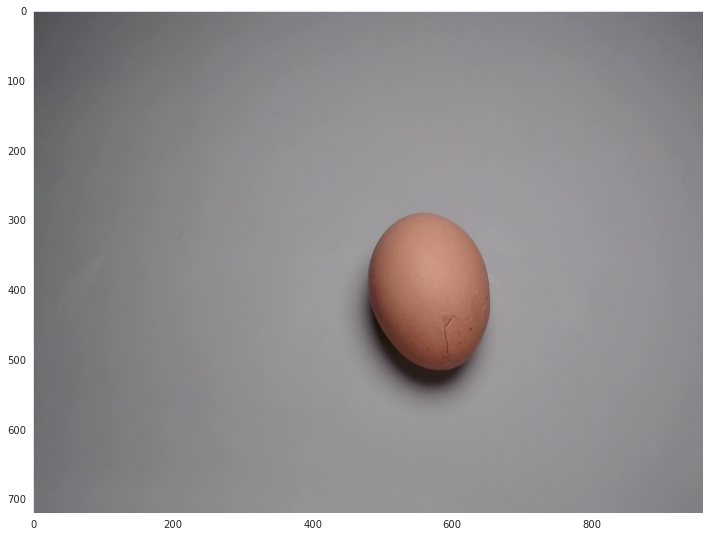

In [3]:
#Testing the above functions
file_path = '6.jpg'
crack1 = rImage(file_path)
print(crack1) #Prints a numpy array of pixel values instead of the image
display(crack1)
print(crack1.shape)

The functions work! So now we can try loading more image data and start messing with some models.

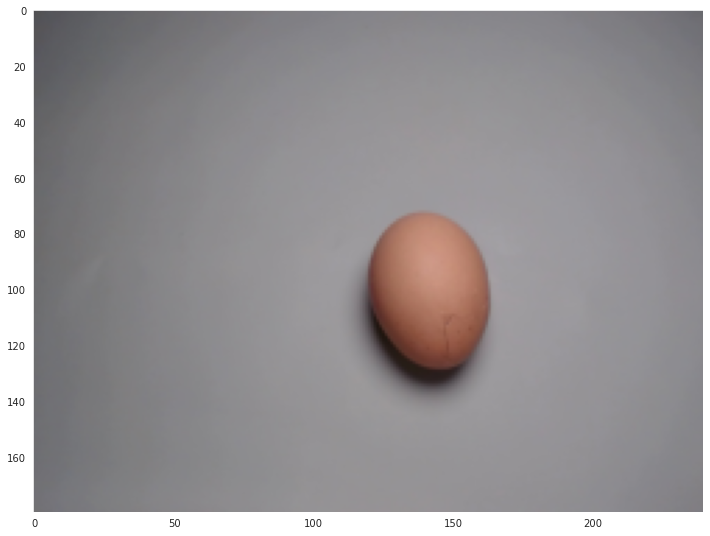

In [4]:
#Our original image size is 960x720, lets try shrinking that down by 4 times and see how the images look:
#Also listing the number of channels in the images. In this case we have RGB images, so 3 channels
# We have three classes of images, crack, good, and empty
resized_height = 180
resized_width = 240
num_channel = 3
num_classes = 3
batch_size = 128

crack2 = skimage.transform.resize(crack1,output_shape=(resized_height,resized_width))
display(crack2)
#Resized! Nice

Now we can try to sort our training data. Since the images are not labeled individually, we may need to mess with some things for the model to recognize the three classes: crack, good, empty. In the next steps we read the different train and testing images and resize them for the model

## Model Setup

In [5]:
# Lets load all the training data
# Here we navigate to the training data folder,
# Then, we use image_dataset_from_directory to go to look at the images in the folders, pick out the three classes we have:
# crack, good, empty 
# Then we have inferred labels and rgb images and batch size, resized image, shuffle the images in the folder, interpolate etc.
train_images_dir = 'Eggs/train'
train_images = image_dataset_from_directory(
    train_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=2,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

#Now load the testing data
test_images_dir = 'Eggs/test'
test_images = image_dataset_from_directory(
    test_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=2,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

Found 542 files belonging to 3 classes.


2023-04-24 18:32:35.231499: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 18:32:35.811674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


Found 27 files belonging to 3 classes.


In [11]:
# Here we define our model, starting with the definition we imported very early on in the notebook

# Define the model
model = Sequential()

# Add the first convolutional layer with 32 filters, 3x3 kernel, and 'relu' activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 240, 3)))

# Add max pooling layer with 2x2 pool size
model.add(MaxPool2D(pool_size=(2, 2)))

# Add the second convolutional layer with 64 filters, 3x3 kernel, and 'relu' activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add max pooling layer with 2x2 pool size
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the feature maps to a 1D vector
model.add(Flatten())

# Add a fully connected layer with 128 units and 'relu' activation
model.add(Dense(128, activation='relu'))

# Add an output layer with 3 units (one for each class) and 'softmax' activation
model.add(Dense(3, activation='softmax'))

In [12]:
# Compile the model with 'categorical_crossentropy' loss, 'adam' optimizer, and accuracy metric
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001, we can modify this value later
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
model.summary() #Shows us our model, only a couple of layers!

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 238, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 119, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 117, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 58, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 159616)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [14]:
# Here we can use model.fit to fit the model we made to our training images, then test them against our validation images!
# For now we will test with just 5 epochs to see if the model works
history = model.fit(train_images, batch_size=batch_size, epochs=5, verbose=1, validation_data=test_images) 

Epoch 1/5


2023-04-24 18:35:53.405289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-04-24 18:35:54.485667: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-24 18:35:54.624246: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-24 18:35:55.619063: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5/5 [==============================] - 9s 161ms/step - loss: 3845.1582 - accuracy: 0.3395 - val_loss: 730.9330 - val_accuracy: 0.3704
Epoch 2/5
5/5 [==============================] - 4s 96ms/step - loss: 525.4981 - accuracy: 0.3266 - val_loss: 107.9703 - val_accuracy: 0.2593
Epoch 3/5
5/5 [==============================] - 4s 94ms/step - loss: 75.0624 - accuracy: 0.3155 - val_loss: 6.0269 - val_accuracy: 0.3704
Epoch 4/5
5/5 [==============================] - 4s 98ms/step - loss: 9.8008 - accuracy: 0.3303 - val_loss: 1.1174 - val_accuracy: 0.8519
Epoch 5/5
5/5 [==============================] - 4s 97ms/step - loss: 0.8331 - accuracy: 0.8524 - val_loss: 2.3180 - val_accuracy: 0.7407


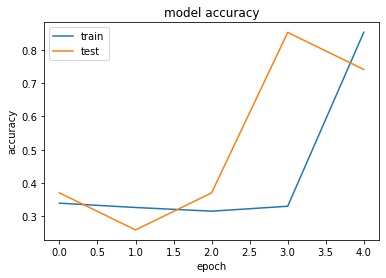

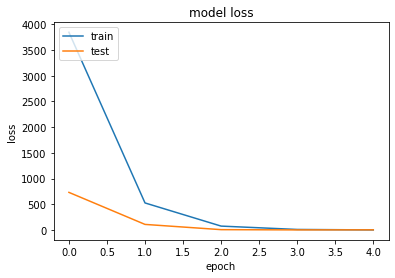

In [15]:
plot_history(history)

In [ ]:
# Okay this seems like a good start, we can test with more epochs and see if we need to modify more hyperparameters

## Hyperparameter Tuning

In [16]:
history = model.fit(train_images, batch_size=batch_size, epochs=20, verbose=1, validation_data=test_images)

Epoch 1/20
5/5 [==============================] - 4s 97ms/step - loss: 0.6993 - accuracy: 0.8247 - val_loss: 3.1379 - val_accuracy: 0.5556
Epoch 2/20
5/5 [==============================] - 4s 95ms/step - loss: 1.4783 - accuracy: 0.8081 - val_loss: 3.2962 - val_accuracy: 0.3704
Epoch 3/20
5/5 [==============================] - 4s 100ms/step - loss: 1.1693 - accuracy: 0.7565 - val_loss: 0.5827 - val_accuracy: 0.8889
Epoch 4/20
5/5 [==============================] - 4s 99ms/step - loss: 0.6938 - accuracy: 0.8819 - val_loss: 1.2288 - val_accuracy: 0.8519
Epoch 5/20
5/5 [==============================] - 4s 97ms/step - loss: 0.7447 - accuracy: 0.8690 - val_loss: 0.8788 - val_accuracy: 0.8889
Epoch 6/20
5/5 [==============================] - 4s 94ms/step - loss: 0.6536 - accuracy: 0.8893 - val_loss: 0.7762 - val_accuracy: 0.9259
Epoch 7/20
5/5 [==============================] - 4s 98ms/step - loss: 0.5974 - accuracy: 0.9004 - val_loss: 0.8259 - val_accuracy: 0.8889
Epoch 8/20
5/5 [==========

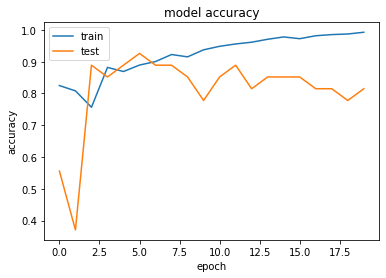

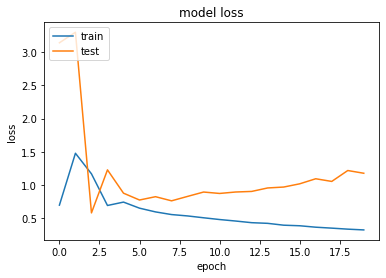

In [17]:
plot_history(history)

Looks like we can try to get our Testing testing accuracy a little higher, lets try changing our batch size. I will try splitting it in half and updating anything that used batch_size

In [78]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 240, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

batch_size = 64
train_images_dir = 'Eggs/train'
train_images = image_dataset_from_directory(
    train_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=3,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

#Now load the testing data
test_images_dir = 'Eggs/test'
test_images = image_dataset_from_directory(
    test_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=3,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001, we can modify this value later
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Found 542 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


In [79]:
history = model.fit(train_images, batch_size=batch_size, epochs=20, verbose=1, validation_data=test_images)

Epoch 1/20
9/9 [==============================] - 5s 57ms/step - loss: 702.5566 - accuracy: 0.3635 - val_loss: 17.2460 - val_accuracy: 0.3704
Epoch 2/20
9/9 [==============================] - 4s 45ms/step - loss: 7.2538 - accuracy: 0.5074 - val_loss: 6.0143 - val_accuracy: 0.3704
Epoch 3/20
9/9 [==============================] - 4s 48ms/step - loss: 1.6466 - accuracy: 0.7306 - val_loss: 1.4661 - val_accuracy: 0.4815
Epoch 4/20
9/9 [==============================] - 4s 46ms/step - loss: 0.3560 - accuracy: 0.8413 - val_loss: 0.4792 - val_accuracy: 0.9259
Epoch 5/20
9/9 [==============================] - 4s 44ms/step - loss: 0.3223 - accuracy: 0.8653 - val_loss: 1.2060 - val_accuracy: 0.6667
Epoch 6/20
9/9 [==============================] - 4s 48ms/step - loss: 0.4255 - accuracy: 0.8524 - val_loss: 0.4075 - val_accuracy: 0.8889
Epoch 7/20
9/9 [==============================] - 4s 47ms/step - loss: 0.2556 - accuracy: 0.8948 - val_loss: 0.5297 - val_accuracy: 0.8519
Epoch 8/20
9/9 [========

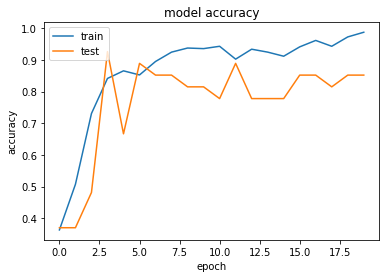

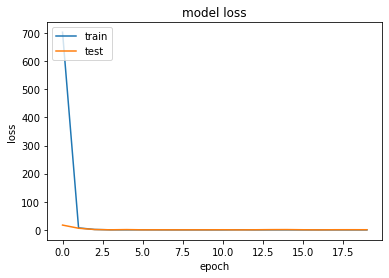

In [80]:
plot_history(history)

Let us see what happens when we decrease batch size even further

In [81]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 240, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

batch_size = 32
train_images_dir = 'Eggs/train'
train_images = image_dataset_from_directory(
    train_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=4,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

#Now load the testing data
test_images_dir = 'Eggs/test'
test_images = image_dataset_from_directory(
    test_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=4,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001, we can modify this value later
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Found 542 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


In [82]:
history = model.fit(train_images, batch_size=batch_size, epochs=20, verbose=1, validation_data=test_images)

Epoch 1/20
17/17 [==============================] - 5s 144ms/step - loss: 639.0618 - accuracy: 0.3782 - val_loss: 1.2602 - val_accuracy: 0.4444
Epoch 2/20
17/17 [==============================] - 4s 139ms/step - loss: 0.7620 - accuracy: 0.6052 - val_loss: 1.0780 - val_accuracy: 0.7037
Epoch 3/20
17/17 [==============================] - 4s 139ms/step - loss: 1.1281 - accuracy: 0.8653 - val_loss: 1.0044 - val_accuracy: 0.8148
Epoch 4/20
17/17 [==============================] - 4s 138ms/step - loss: 0.8282 - accuracy: 0.8911 - val_loss: 0.8288 - val_accuracy: 0.8519
Epoch 5/20
17/17 [==============================] - 4s 139ms/step - loss: 0.6223 - accuracy: 0.8985 - val_loss: 0.9479 - val_accuracy: 0.8519
Epoch 6/20
17/17 [==============================] - 4s 140ms/step - loss: 0.5290 - accuracy: 0.9410 - val_loss: 1.0895 - val_accuracy: 0.8519
Epoch 7/20
17/17 [==============================] - 4s 138ms/step - loss: 0.4478 - accuracy: 0.9613 - val_loss: 1.4010 - val_accuracy: 0.8519
Epoc

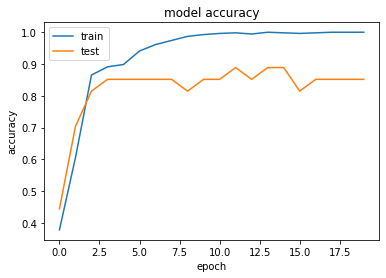

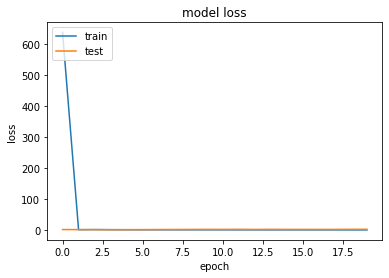

In [83]:
plot_history(history)

In [84]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 240, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

batch_size = 16
train_images_dir = 'Eggs/train'
train_images = image_dataset_from_directory(
    train_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=6,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

#Now load the testing data
test_images_dir = 'Eggs/test'
test_images = image_dataset_from_directory(
    test_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=6,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001, we can modify this value later
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Found 542 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


In [85]:
history = model.fit(train_images, batch_size=batch_size, epochs=20, verbose=1, validation_data=test_images)

Epoch 1/20
34/34 [==============================] - 5s 103ms/step - loss: 467.7116 - accuracy: 0.5609 - val_loss: 1.2851 - val_accuracy: 0.9259
Epoch 2/20
34/34 [==============================] - 4s 101ms/step - loss: 0.6800 - accuracy: 0.8708 - val_loss: 0.7157 - val_accuracy: 0.8148
Epoch 3/20
34/34 [==============================] - 4s 101ms/step - loss: 0.5690 - accuracy: 0.9077 - val_loss: 0.7403 - val_accuracy: 0.8889
Epoch 4/20
34/34 [==============================] - 4s 101ms/step - loss: 0.4796 - accuracy: 0.9207 - val_loss: 0.8137 - val_accuracy: 0.8519
Epoch 5/20
34/34 [==============================] - 4s 100ms/step - loss: 0.3972 - accuracy: 0.9502 - val_loss: 0.7082 - val_accuracy: 0.8519
Epoch 6/20
34/34 [==============================] - 4s 100ms/step - loss: 0.3147 - accuracy: 0.9668 - val_loss: 0.7927 - val_accuracy: 0.8889
Epoch 7/20
34/34 [==============================] - 4s 101ms/step - loss: 0.2453 - accuracy: 0.9742 - val_loss: 0.8535 - val_accuracy: 0.8889
Epoc

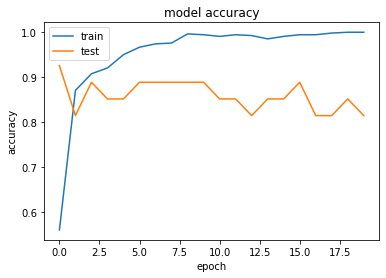

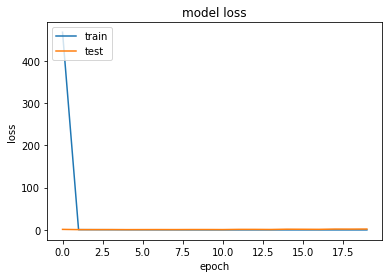

In [86]:
plot_history(history)

### Going back to 128, as well as changing the label mode int and compiling using sparse_categorical_crossentropy since the labels are not actually categorical to see how the model works with that

In [99]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 240, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

batch_size = 128
train_images_dir = 'Eggs/train'
train_images = image_dataset_from_directory(
    train_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=1,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

#Now load the testing data
test_images_dir = 'Eggs/test'
test_images = image_dataset_from_directory(
    test_images_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=1,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001, we can modify this value later
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Found 542 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


In [100]:
history = model.fit(train_images, batch_size=batch_size, epochs=10, verbose=1, validation_data=test_images)

Epoch 1/10
5/5 [==============================] - 5s 121ms/step - loss: 4421.4287 - accuracy: 0.3247 - val_loss: 1078.5236 - val_accuracy: 0.2593
Epoch 2/10
5/5 [==============================] - 4s 102ms/step - loss: 507.2767 - accuracy: 0.3321 - val_loss: 44.4533 - val_accuracy: 0.2593
Epoch 3/10
5/5 [==============================] - 4s 102ms/step - loss: 19.0888 - accuracy: 0.4336 - val_loss: 3.0318 - val_accuracy: 0.7037
Epoch 4/10
5/5 [==============================] - 4s 101ms/step - loss: 13.6327 - accuracy: 0.4207 - val_loss: 20.5362 - val_accuracy: 0.3704
Epoch 5/10
5/5 [==============================] - 4s 102ms/step - loss: 10.8205 - accuracy: 0.4280 - val_loss: 4.7940 - val_accuracy: 0.6296
Epoch 6/10
5/5 [==============================] - 4s 96ms/step - loss: 1.6909 - accuracy: 0.8137 - val_loss: 4.0352 - val_accuracy: 0.7407
Epoch 7/10
5/5 [==============================] - 4s 102ms/step - loss: 1.3510 - accuracy: 0.8524 - val_loss: 1.6361 - val_accuracy: 0.7778
Epoch 8/

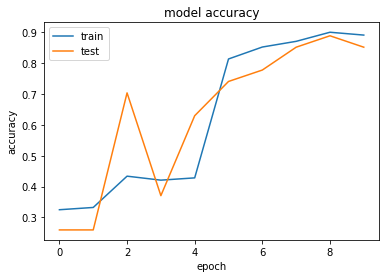

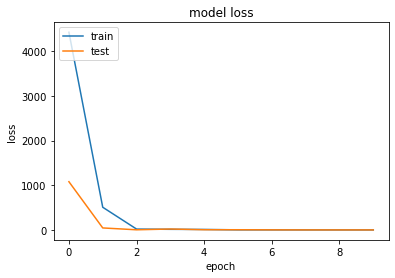

In [101]:
plot_history(history)

## Results and Discussion

Overall the model scored pretty high. It could score higher with more tuning and some more variation on the images but I should be around the 10 minute mark for the presentation. I will attempt to calculate a confusion matrix to see how it is dealing with false negatives and such.

Confusion Matrix:
[[ 0 10  0]
 [ 3  0  7]
 [ 6  0  1]]


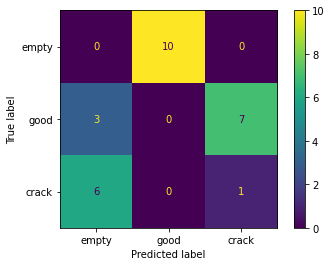

In [102]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the expected input size for the model
input_size = (240, 180)

# Define the list of ground truth and predicted labels
class_names = ['empty', 'good', 'crack']  # Update this with your actual class names
y_true = []
y_pred = []

# Loop through the test folder directory
test_folder_dir = 'Eggs/test'  # Update this with your actual test folder directory
class_folders = os.listdir(test_folder_dir)
for class_folder in class_folders:
    class_folder_dir = os.path.join(test_folder_dir, class_folder)
    image_filenames = os.listdir(class_folder_dir)
    for image_filename in image_filenames:
        image_filepath = os.path.join(class_folder_dir, image_filename)

        # Load and resize the image
        image = Image.open(image_filepath)
        image = image.resize(input_size)
        image = np.array(image)
        image = np.expand_dims(image, axis=0)

        # Obtain the predicted class label
        predicted_label = model.predict(image)  # Update this line with your actual prediction logic
        predicted_label = class_names[np.argmax(predicted_label)]  # Update this line with your actual prediction logic

        # Append the predicted and ground truth labels to the lists
        y_pred.append(predicted_label)
        y_true.append(class_folder)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_names)
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names).plot()
print("Confusion Matrix:")
print(cm)


Well that's not good at all. We had high accuracy in the model but it seems it was not training or validating well.

One way to improve our results is to get better variation in the training data and change all the labels to numbers rather than dates and such. Creating more variation in the traiining can ensure that the model can be ready for the possible variations in the testing set. As it stands now, we seem to only have one correctly identified image in the testing set, but the model is showing us high accuracy. 

SyntaxError: invalid syntax (3857433200.py, line 1)